In [1]:
# import libraries
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import MapboxTiles
import geopandas as gpd
import os
from dotenv import load_dotenv
import random
load_dotenv() # loads .env file from main folder

True

In [4]:
# load parcel and building data
df_parcels = gpd.read_file(os.environ.get('LOCAL_PATH')+"Data/Parcels/NYC_2021_Tax_Parcels_SHP_2203/NewYork_2021_Tax_Parcels_SHP_2203.shp")
df_buildings = gpd.read_file(os.environ.get('LOCAL_PATH')+"Data/Building Footprints/NYC/geo_export_a80ea1a2-e8e0-4ffd-862c-1199433ac303.shp")

In [5]:
# set random RGB color for the parcels
def random_hex_color():
  r = random.randint(0, 255)
  g = random.randint(0, 255)
  b = random.randint(0, 255)
  return "#{:02x}{:02x}{:02x}".format(r, g, b)
random_hex_color()
df_parcels['color'] = [ random_hex_color() for i in range(len(df_parcels)) ]

In [6]:
# set CRS to web mercator
df_parcels = df_parcels.to_crs(epsg=3857)
df_buildings = df_buildings.to_crs(epsg=3857)

In [7]:
# load the background map and plot the geometries
def map_maker(df_parcels, df_buildings, scale=10):
    access_token = os.environ.get('MAPBOX_ACCESS_TOKEN')
    tiler = MapboxTiles(access_token, 'satellite-v9')
    crs_epsg = ccrs.epsg('3857')

    mercator = tiler.crs

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection=mercator)
    # change figure size of the subplot
    fig.set_size_inches(18.5, 10.5)

    bounds = df_parcels.total_bounds
    ax.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], crs=ccrs.epsg("3857"))
    # loop through the parcels and plot them
    for row in df_parcels.itertuples():
        # df_parcels.iloc[i:i+1].plot(color=df_parcels.iloc[i:i+1].color.values[0])
        geometry = row.geometry
        color = row.color
        ax.add_geometries(geometry, crs = crs_epsg, facecolor=color) # for Lat/Lon data.

    ax.add_geometries(df_buildings.geometry, crs = crs_epsg, facecolor='black', edgecolor='white', linewidth=1.5, alpha=1)

    # add the Mabox tiles to the axis at zoom level 10 (Mapbox has 23 zoom levels)
    ax.add_image(tiler, scale)

    # ax.coastlines('10m')
    plt.show()

In [8]:
# subset the data frames based on a buffer
def subset(df, df_buildings, index, distance = 75):
    selected_feature = df.loc[index]
    geometry_buffer = selected_feature.geometry.buffer(distance)

    return df[df.within(geometry_buffer)], df_buildings[df_buildings.within(geometry_buffer)]

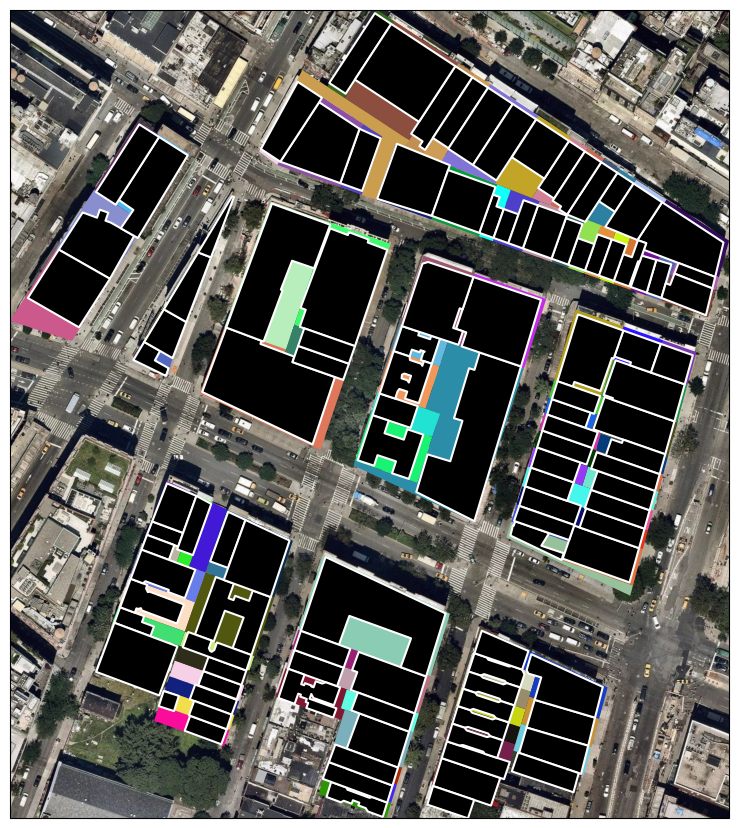

In [9]:
# Index will correspond to each of the parcel indices in the data frame. 
# distance is in meters
subset_features = subset(df_parcels, df_buildings, 2000, 200)
map_maker(subset_features[0], subset_features[1], 18)